# LTM Model Fits - Example Usage Notebook

This notebook demonstrates:
1. Loading pre-computed model fits
2. Extracting p-values
3. Plotting model fits
4. Verifying correctness


## 1. Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

plt.rcParams['figure.dpi'] = 100

## 2. Configuration

Set the paths and filenames for your data:

In [3]:
BASE_PATH = '/Users/lana/Desktop/psychoPyExperiments/wm_deepgen_full/'

MODEL_FITS_IT_FILE = 'experiment_accuracy_fits_it'
MODEL_FITS_V2_FILE = 'experiment_accuracy_fits_v2'
DATA_FILE = 'enhanced_df.csv'

IT_X_COL = 'LTM - NonLTM IT Distractor Similarity'
V2_X_COL = 'LTM - NonLTM V2 Distractor Similarity'

## 3. Helper Functions - Load Model Fits

In [4]:
def load_model_fits(filename):
    """
    Load model fits from pickle or json file.

    Args:
        filename: Base filename (without extension)

    Returns:
        Dictionary containing model fits structure
    """
    import json

    pickle_file = f"{filename}.pkl"
    json_file = f"{filename}.json"

    if os.path.exists(pickle_file):
        with open(pickle_file, 'rb') as f:
            return pickle.load(f)
    elif os.path.exists(json_file):
        with open(json_file, 'r') as f:
            return json.load(f)
    else:
        raise FileNotFoundError(f"Neither {pickle_file} nor {json_file} found")




## 4. Helper Functions - Extract P-Values

In [5]:
def _flipped_p_from_model(model_fits_data, row_idx, x_vals):
    """
    For each x value, interpolate 1-p (flipped p-value) from the model.

    This function:
    1. Determines if each x is on left (x ≤ 0) or right (x > 0) side
    2. Gets the appropriate model for that side
    3. Interpolates 1 - y_value from the model

    Args:
        model_fits_data: Loaded model fits dictionary
        row_idx: Which row to use (1 for Accuracy)
        x_vals: Array of x-values to get predictions for

    Returns:
        Array of interpolated 1-p values (flipped predictions)
    """
    x_vals = np.asarray(x_vals, dtype=float)
    out = np.full(x_vals.shape, np.nan, dtype=float)

    row_key = f"row_{row_idx}"
    mf = model_fits_data[row_key]['model_fits']

    for side, mask in [('left', x_vals <= 0), ('right', x_vals > 0)]:
        if not np.any(mask):
            continue

        side_dict = mf.get(f"{side}_side", {})
        if not side_dict:
            continue

        # Get the first (and only) item
        first_key = next(iter(side_dict))
        fit = side_dict[first_key]

        # Extract model data
        x_fit = np.asarray(fit['x_values'], dtype=float)
        y_fit = np.asarray(fit['y_values'], dtype=float)

        # Interpolate 1 - y for this side
        out[mask] = np.interp(x_vals[mask], x_fit, 1.0 - y_fit)

    return out




In [6]:
def attach_flipped_ps(df, it_x_col, v2_x_col, model_fits_it, model_fits_v2, row_idx=1):
    """
    Add flipped p-values to dataframe.

    Creates two new columns:
    - p_it_flipped: 1 - p(x) from IT model
    - p_v2_flipped: 1 - p(x) from V2 model

    Args:
        df: Dataframe with similarity columns
        it_x_col: Name of IT similarity column
        v2_x_col: Name of V2 similarity column
        model_fits_it: IT model fits dictionary
        model_fits_v2: V2 model fits dictionary
        row_idx: Which row to use (default 1 for Accuracy)

    Returns:
        Copy of dataframe with new p-value columns
    """
    out = df.copy()
    out['p_it_flipped'] = _flipped_p_from_model(
        model_fits_it, row_idx, out[it_x_col].to_numpy()
    )
    out['p_v2_flipped'] = _flipped_p_from_model(
        model_fits_v2, row_idx, out[v2_x_col].to_numpy()
    )
    return out




## 5. Helper Functions - Inspect Model Structure

In [7]:
def inspect_model_structure(model_fits, name='Model'):
    """Print detailed structure of model fits"""
    print(f"\n{'='*80}")
    print(f"{name} Structure")
    print(f"{'='*80}")

    for row_key, row_data in model_fits.items():
        print(f"\n{row_key}:")
        print(f"  Config:")
        for k, v in row_data['config'].items():
            print(f"    {k}: {v}")

        print(f"  Source: {row_data['source']}")

        mf = row_data['model_fits']
        for side_key in ['left_side', 'right_side']:
            if side_key in mf:
                print(f"\n  {side_key}:")
                side_data = mf[side_key]

                for item_name, item_data in side_data.items():
                    print(f"    {item_name}:")

                    x_vals = np.array(item_data['x_values'])
                    y_vals = np.array(item_data['y_values'])

                    print(f"      x_values: {len(x_vals)} points")
                    print(f"        range: [{x_vals.min():.4f}, {x_vals.max():.4f}]")

                    print(f"      y_values (accuracy): {len(y_vals)} points")
                    print(f"        range: [{y_vals.min():.4f}, {y_vals.max():.4f}]")

                    flipped = 1 - y_vals
                    print(f"      1-y (flipped/error): {len(flipped)} points")
                    print(f"        range: [{flipped.min():.4f}, {flipped.max():.4f}]")

                    print(f"      model_order: {item_data['model_order']}")
                    print(f"      model_coefficients: {item_data['model_coefficients']}")




## 6. Helper Functions - Plot Model Fits

In [8]:
def plot_model_fits(model_fits, title, color='#49a791', figsize=(15, 5)):
    """
    Plot the model fits (left, right, and combined).

    Args:
        model_fits: Loaded model fits dictionary
        title: Plot title
        color: Color for the model curves
        figsize: Figure size tuple
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    row_data = model_fits['row_1']
    model_fits_data = row_data['model_fits']

    # LEFT SIDE
    left_data = model_fits_data['left_side']['all_data']
    x_left = np.array(left_data['x_values'])
    y_left = np.array(left_data['y_values'])
    y_flipped_left = 1 - y_left

    axes[0].plot(x_left, y_left, color=color, linewidth=3, label='Accuracy (p)')
    axes[0].axvline(0, color='grey', linestyle='--', alpha=0.5)
    axes[0].set_title(f'{title} - Left Side (x ≤ 0)', fontweight='bold')
    axes[0].set_xlabel('Similarity', fontweight='bold')
    axes[0].set_ylabel('Accuracy', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # RIGHT SIDE
    right_data = model_fits_data['right_side']['all_data']
    x_right = np.array(right_data['x_values'])
    y_right = np.array(right_data['y_values'])
    y_flipped_right = 1 - y_right

    axes[1].plot(x_right, y_right, color=color, linewidth=3, label='Accuracy (p)')
    axes[1].axvline(0, color='grey', linestyle='--', alpha=0.5)
    axes[1].set_title(f'{title} - Right Side (x > 0)', fontweight='bold')
    axes[1].set_xlabel('Similarity', fontweight='bold')
    axes[1].set_ylabel('Accuracy', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # COMBINED (p and 1-p)
    axes[2].plot(x_left, y_left, color=color, linewidth=3,
                label='p (Accuracy)', alpha=0.8)
    axes[2].plot(x_right, y_right, color=color, linewidth=3, alpha=0.8)

    axes[2].plot(x_left, y_flipped_left, color='red', linewidth=2,
                label='1-p (Error)', linestyle='--', alpha=0.8)
    axes[2].plot(x_right, y_flipped_right, color='red', linewidth=2,
                linestyle='--', alpha=0.8)

    axes[2].axvline(0, color='grey', linestyle='--', alpha=0.5)
    axes[2].axhline(0.5, color='grey', linestyle=':', alpha=0.3)
    axes[2].set_title(f'{title} - Combined', fontweight='bold')
    axes[2].set_xlabel('Similarity', fontweight='bold')
    axes[2].set_ylabel('Probability', fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()




## 7. Helper Functions - Plot Data

In [9]:
def plot_data_with_model(df, x_col, p_col, p_flipped_col, title, figsize=(12, 5)):
    """
    Plot dataframe values colored by p-values.

    Args:
        df: Dataframe with data
        x_col: Name of x (similarity) column
        p_col: Name of regular p-value column
        p_flipped_col: Name of flipped p-value column
        title: Plot title
        figsize: Figure size
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Plot 1: Regular p-values (Accuracy)
    scatter1 = axes[0].scatter(df[x_col], df[p_col],
                              c=df[p_col], cmap='viridis',
                              s=5, alpha=0.5, edgecolors='none')
    axes[0].axvline(0, color='grey', linestyle='--', alpha=0.5)
    axes[0].set_xlabel('Similarity', fontweight='bold')
    axes[0].set_ylabel('p (Accuracy)', fontweight='bold')
    axes[0].set_title(f'{title} - Regular p-values', fontweight='bold')
    plt.colorbar(scatter1, ax=axes[0], label='Accuracy')
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Flipped p-values (Error)
    scatter2 = axes[1].scatter(df[x_col], df[p_flipped_col],
                              c=df[p_flipped_col], cmap='plasma',
                              s=5, alpha=0.5, edgecolors='none')
    axes[1].axvline(0, color='grey', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Similarity', fontweight='bold')
    axes[1].set_ylabel('1-p (Error Probability)', fontweight='bold')
    axes[1].set_title(f'{title} - Flipped p-values (1-p)', fontweight='bold')
    plt.colorbar(scatter2, ax=axes[1], label='Error Prob')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()




## 8. Helper Functions - Verify Extraction

In [10]:
def verify_extraction(df, model_fits_it, model_fits_v2):
    """
    Verify that the p-value extraction is correct.

    Performs multiple checks:
    1. Range check: dataframe values within model ranges
    2. Sum check: p + (1-p) = 1
    3. Manual interpolation check
    """
    print(f"\n{'='*80}")
    print("VERIFICATION OF P-VALUE EXTRACTION")
    print(f"{'='*80}")

    # Check 1: Ranges
    print("\n1. Range Verification:")
    print("-" * 40)

    # IT ranges
    row_1 = model_fits_it['row_1']['model_fits']
    left_y_it = np.array(row_1['left_side']['all_data']['y_values'])
    right_y_it = np.array(row_1['right_side']['all_data']['y_values'])

    print(f"IT Model y range: [{min(left_y_it.min(), right_y_it.min()):.4f}, "
          f"{max(left_y_it.max(), right_y_it.max()):.4f}]")
    print(f"IT Data p_values_it_ltm range: [{df['p_values_it_ltm'].min():.4f}, "
          f"{df['p_values_it_ltm'].max():.4f}]")

    if (df['p_values_it_ltm'].min() >= min(left_y_it.min(), right_y_it.min()) - 0.01 and
        df['p_values_it_ltm'].max() <= max(left_y_it.max(), right_y_it.max()) + 0.01):
        print("✅ IT ranges match!")
    else:
        print("❌ IT ranges don't match - possible error")

    # V2 ranges
    row_1_v2 = model_fits_v2['row_1']['model_fits']
    left_y_v2 = np.array(row_1_v2['left_side']['all_data']['y_values'])
    right_y_v2 = np.array(row_1_v2['right_side']['all_data']['y_values'])

    print(f"\nV2 Model y range: [{min(left_y_v2.min(), right_y_v2.min()):.4f}, "
          f"{max(left_y_v2.max(), right_y_v2.max()):.4f}]")
    print(f"V2 Data p_values_v2_ltm range: [{df['p_values_v2_ltm'].min():.4f}, "
          f"{df['p_values_v2_ltm'].max():.4f}]")

    if (df['p_values_v2_ltm'].min() >= min(left_y_v2.min(), right_y_v2.min()) - 0.01 and
        df['p_values_v2_ltm'].max() <= max(left_y_v2.max(), right_y_v2.max()) + 0.01):
        print("✅ V2 ranges match!")
    else:
        print("❌ V2 ranges don't match - possible error")

    # Check 2: Sum to 1
    print("\n2. Sum Verification (p + (1-p) should equal 1):")
    print("-" * 40)

    it_sum = df['p_values_it_ltm'] + df['p_values_it_flipped_ltm']
    v2_sum = df['p_values_v2_ltm'] + df['p_values_v2_flipped_ltm']

    print(f"IT: mean={it_sum.mean():.10f}, std={it_sum.std():.10f}")
    print(f"V2: mean={v2_sum.mean():.10f}, std={v2_sum.std():.10f}")

    if abs(it_sum.mean() - 1.0) < 1e-6 and abs(v2_sum.mean() - 1.0) < 1e-6:
        print("✅ Sums are correct!")
    else:
        print("❌ Sums don't equal 1 - possible error")

    # Check 3: Manual interpolation
    print("\n3. Manual Interpolation Verification:")
    print("-" * 40)

    # Pick a test point
    test_row = df.iloc[100]
    it_x = test_row[IT_X_COL]

    # Manual interpolation
    if it_x <= 0:
        side_data = row_1['left_side']['all_data']
        side_name = 'left'
    else:
        side_data = row_1['right_side']['all_data']
        side_name = 'right'

    x_fit = np.array(side_data['x_values'])
    y_fit = np.array(side_data['y_values'])

    manual_p = np.interp(it_x, x_fit, y_fit)
    manual_p_flipped = np.interp(it_x, x_fit, 1 - y_fit)

    df_p = test_row['p_values_it_ltm']
    df_p_flipped = test_row['p_values_it_flipped_ltm']

    print(f"Test point: IT x = {it_x:.4f} (on {side_name} side)")
    print(f"Manual interpolation:")
    print(f"  p = {manual_p:.6f}, 1-p = {manual_p_flipped:.6f}")
    print(f"Dataframe values:")
    print(f"  p = {df_p:.6f}, 1-p = {df_p_flipped:.6f}")
    print(f"Difference:")
    print(f"  p: {abs(manual_p - df_p):.10f}")
    print(f"  1-p: {abs(manual_p_flipped - df_p_flipped):.10f}")

    if abs(manual_p - df_p) < 1e-6 and abs(manual_p_flipped - df_p_flipped) < 1e-6:
        print("✅ Manual interpolation matches!")
    else:
        print("❌ Manual interpolation doesn't match - possible error")

    print(f"\n{'='*80}")
    print("VERIFICATION COMPLETE")
    print(f"{'='*80}")




## 9. Load Model Fits

Load the pre-computed polynomial models:

In [11]:
model_fits_it = load_model_fits(BASE_PATH + MODEL_FITS_IT_FILE)
model_fits_v2 = load_model_fits(BASE_PATH + MODEL_FITS_V2_FILE)

print('✅ Model fits loaded successfully!')

✅ Model fits loaded successfully!


## 10. Inspect Model Structure

In [12]:
inspect_model_structure(model_fits_it, 'IT Model')


IT Model Structure

row_1:
  Config:
    x_col: Tested - Untested IT Distractor Similarity
    y_col: Accuracy
    item_col: None
    model_orders: {'left': 3, 'right': 3}
    trim_percentile: 0
    window_percent: 0.1
    step_percent: 0.01
  Source: continuous_rolling_average

  left_side:
    all_data:
      x_values: 100 points
        range: [-1.1489, 0.0000]
      y_values (accuracy): 100 points
        range: [0.7124, 0.7641]
      1-y (flipped/error): 100 points
        range: [0.2359, 0.2876]
      model_order: 3
      model_coefficients: [-0.17325445698161693, -0.32663772068328706, -0.11313166600770598, 0.7531896155641523]

  right_side:
    all_data:
      x_values: 100 points
        range: [0.0000, 1.1460]
      y_values (accuracy): 100 points
        range: [0.7444, 0.7728]
      1-y (flipped/error): 100 points
        range: [0.2272, 0.2556]
      model_order: 3
      model_coefficients: [-0.27650136651466656, 0.4851591700440949, -0.21557662722823018, 0.7728326067549836

In [13]:
inspect_model_structure(model_fits_v2, 'V2 Model')


V2 Model Structure

row_1:
  Config:
    x_col: Tested - Untested V2 Distractor Similarity
    y_col: Accuracy
    item_col: None
    model_orders: {'left': 3, 'right': 3}
    trim_percentile: 0
    window_percent: 0.1
    step_percent: 0.01
  Source: continuous_rolling_average

  left_side:
    all_data:
      x_values: 100 points
        range: [-0.1498, 0.0000]
      y_values (accuracy): 100 points
        range: [0.7210, 0.7642]
      1-y (flipped/error): 100 points
        range: [0.2358, 0.2790]
      model_order: 3
      model_coefficients: [-62.23744611613539, -18.249658962852106, -1.2021611875618805, 0.741252474165364]

  right_side:
    all_data:
      x_values: 100 points
        range: [0.0000, 0.1496]
      y_values (accuracy): 100 points
        range: [0.7454, 0.7571]
      1-y (flipped/error): 100 points
        range: [0.2429, 0.2546]
      model_order: 3
      model_coefficients: [16.960432969770984, -2.8601798376234964, 0.0037269361680472316, 0.7570643624263751]


## 11. Load Data

In [14]:
df = pd.read_csv(BASE_PATH + DATA_FILE)

print(f'Dataframe shape: {df.shape}')
print(f'\nP-value columns:')
for col in df.columns:
    if 'p_values' in col.lower() and 'ltm' in col.lower():
        print(f'  - {col}')

Dataframe shape: (15013, 563)

P-value columns:
  - p_values_v2_flipped_ltm
  - p_values_it_flipped_ltm


## 12. Plot Model Fits

### IT Model

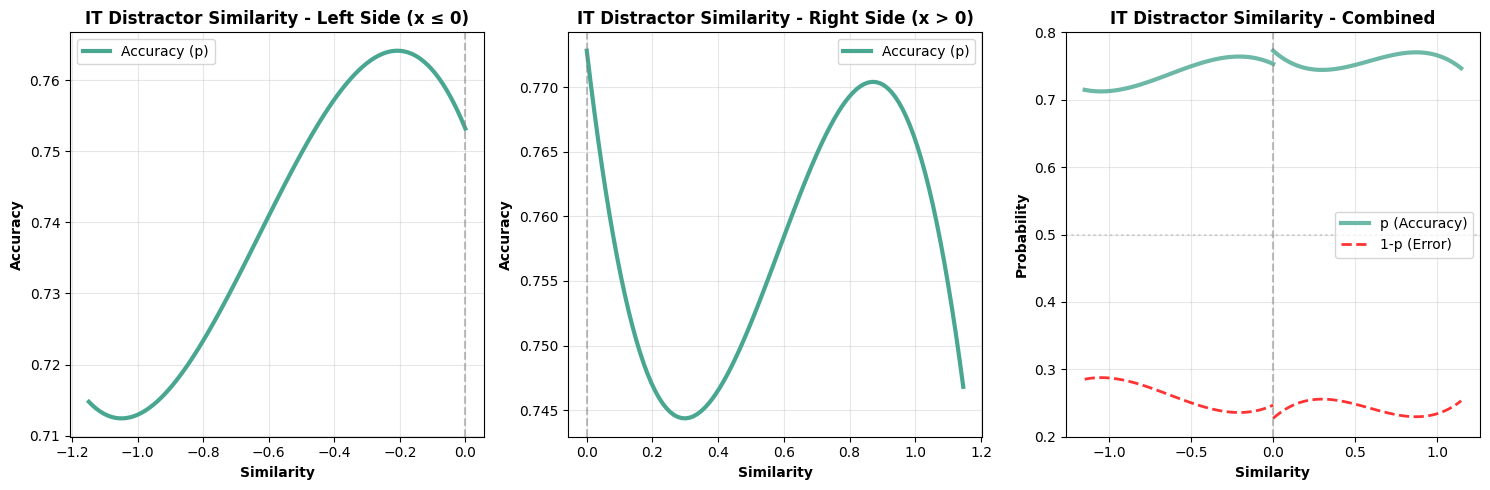

In [15]:
plot_model_fits(model_fits_it, 'IT Distractor Similarity', color='#49a791')

### V2 Model

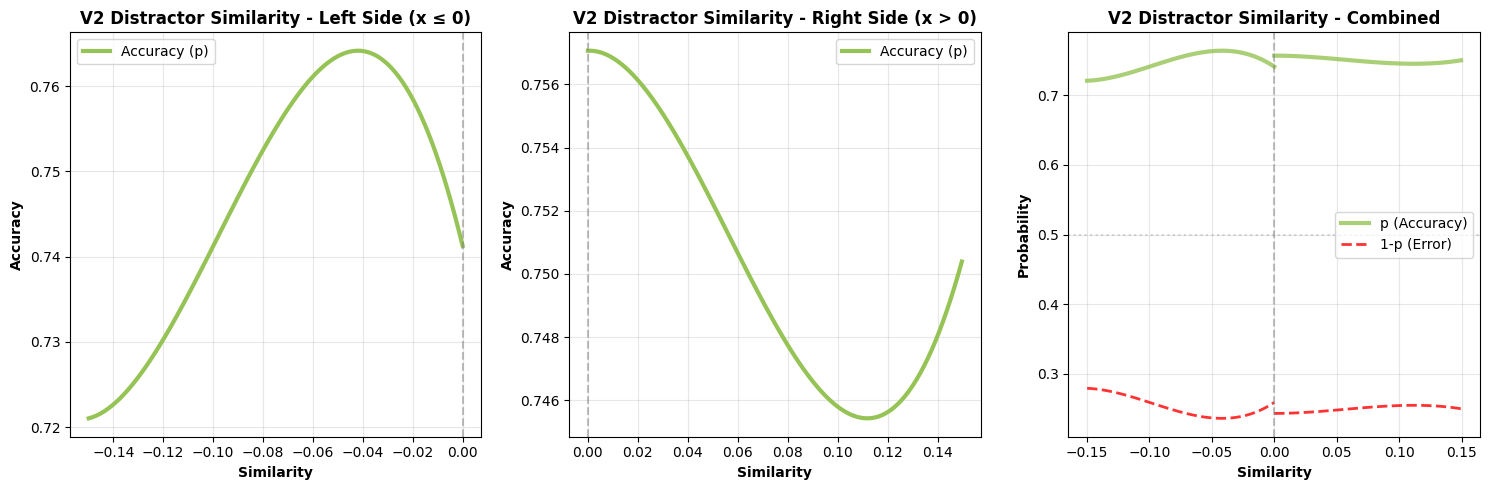

In [16]:
plot_model_fits(model_fits_v2, 'V2 Distractor Similarity', color='#95c355')

## 13. Plot Data with P-Values

### IT Data

KeyError: 'p_values_it_ltm'

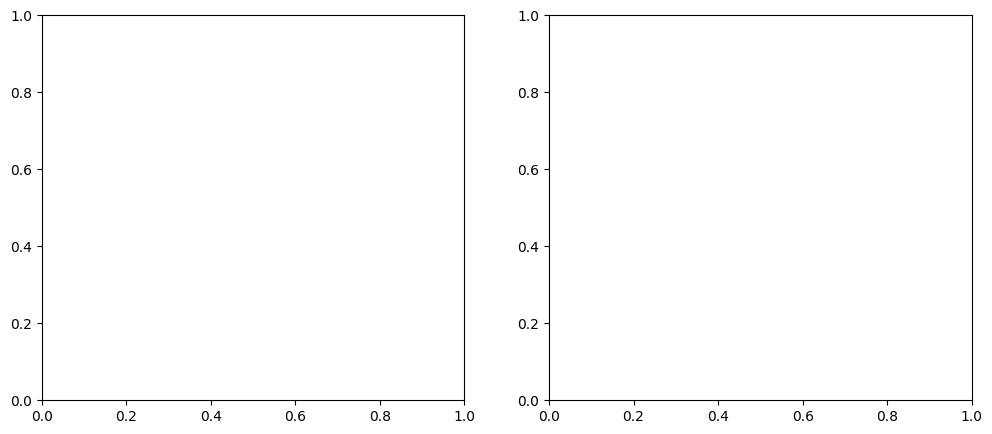

In [17]:
plot_data_with_model(
    df,
    x_col=IT_X_COL,
    p_col='p_values_it_ltm',
    p_flipped_col='p_values_it_flipped_ltm',
    title='IT Distractor Similarity'
)

### V2 Data

In [ ]:
plot_data_with_model(
    df,
    x_col=V2_X_COL,
    p_col='p_values_v2_ltm',
    p_flipped_col='p_values_v2_flipped_ltm',
    title='V2 Distractor Similarity'
)

## 14. Verify Extraction Correctness

In [ ]:
verify_extraction(df, model_fits_it, model_fits_v2)